In [1]:
import pandas as pd
#import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point
#import shapely
import math
import os
from collections import OrderedDict
from EM_Tomo_viz_tools import *
from Create_vector_grid import *
%matplotlib inline
pd.options.mode.chained_assignment = None


In [2]:
#Settings:
#check for 3D data only, 2D cannot be worked on
#change to height at -3
#add crs to grid_data and output
#throw out all no-data rows
#Multiple depths
height = -1.5
no_data_value = float('Nan')

input_file2 = "/Users/kazv/Desktop/3d_test_grid/csv_converted_test_grid/csv_converted_test_grid.shp"
output_file2 = "/Users/kazv/Desktop/3d_test_grid/csv_converted_test_grid/kaz_output.shp"


In [3]:
#Read and upgrade basic GDF:
gdf = read_shapefile(input_file2)
gdf['top'] = gdf.elev_boven
gdf['bottom'] = gdf.elev_boven+gdf.Dikte


In [4]:
gdf

,Punt_ID,X,Y,Topo,elev_onder,EC,Dikte,elev_boven,ID,geometry,top,bottom
0,Meetlocatie_1,594158.13,5741660.0,0.88,0.58,21.70,0.3,0.88,0,POINT (594158.13 5741660),0.88,1.18
1,Meetlocatie_2,594186.38,5741660.0,0.80,0.50,26.35,0.3,0.80,1,POINT (594186.38 5741660),0.80,1.10
2,Meetlocatie_3,594214.81,5741660.0,0.79,0.49,26.93,0.3,0.79,2,POINT (594214.8100000001 5741660),0.79,1.09
3,Meetlocatie_4,594243.13,5741660.0,0.78,0.48,28.36,0.3,0.78,3,POINT (594243.13 5741660),0.78,1.08
4,Meetlocatie_5,594271.50,5741660.0,0.76,0.46,30.54,0.3,0.76,4,POINT (594271.5 5741660),0.76,1.06
5,Meetlocatie_6,594299.88,5741660.0,0.75,0.45,32.34,0.3,0.75,5,POINT (594299.88 5741660),0.75,1.05
6,Meetlocatie_7,594328.31,5741660.0,0.68,0.38,40.86,0.3,0.68,6,POINT (594328.3100000001 5741660),0.68,0.98
7,Meetlocatie_8,594356.63,5741660.0,0.58,0.28,47.40,0.3,0.58,7,POINT (594356.63 5741660),0.58,0.88
8,Meetlocatie_9,594158.13,5741689.0,1.13,0.83,17.40,0.3,1.13,8,POINT (594158.13 5741689),1.13,1.43
9,Meetlocatie_10,594186.38,5741689.0,0.99,0.69,18.34,0.3,0.99,9,POINT (594186.38 5741689),0.99,1.29


In [5]:
# if not(isinstance(filetext, str)) || not(isinstance(output_foldertext, str)):
    
    
    
filetext = ''
output_foldertext = 2

if not(isinstance(filetext,str)) or not(isinstance(output_foldertext,str)):
    print('yes')
else:
    print('no')

yes


In [6]:
gdf_filtered = gdf[(gdf.top> height) & (gdf.bottom <= height)]
gdf_filtered

,Punt_ID,X,Y,Topo,elev_onder,EC,Dikte,elev_boven,ID,geometry,top,bottom


In [7]:
gdf[(gdf.elev_boven>height) & (gdf.elev_onder <= height)]


,Punt_ID,X,Y,Topo,elev_onder,EC,Dikte,elev_boven,ID,geometry,top,bottom
2024,Meetlocatie_69,594214.81,5741830.0,-0.63,-1.63,89.17,0.4,-1.23,2024,POINT (594214.8100000001 5741830),-1.23,-0.83
2025,Meetlocatie_70,594243.13,5741830.0,-0.77,-1.77,91.02,0.4,-1.37,2025,POINT (594243.13 5741830),-1.37,-0.97
2026,Meetlocatie_71,594271.50,5741830.0,-0.62,-1.62,97.02,0.4,-1.22,2026,POINT (594271.5 5741830),-1.22,-0.82
2038,Meetlocatie_83,594158.13,5741858.0,-0.86,-1.86,70.40,0.4,-1.46,2038,POINT (594158.13 5741858),-1.46,-1.06
2039,Meetlocatie_84,594186.38,5741858.0,-0.75,-1.75,83.51,0.4,-1.35,2039,POINT (594186.38 5741858),-1.35,-0.95
2040,Meetlocatie_85,594214.81,5741858.0,-0.73,-1.73,82.30,0.4,-1.33,2040,POINT (594214.8100000001 5741858),-1.33,-0.93
2041,Meetlocatie_86,594243.13,5741858.0,-0.70,-1.70,83.66,0.4,-1.30,2041,POINT (594243.13 5741858),-1.30,-0.90
2042,Meetlocatie_87,594271.50,5741858.0,-0.67,-1.67,88.25,0.4,-1.27,2042,POINT (594271.5 5741858),-1.27,-0.87
2043,Meetlocatie_88,594299.88,5741858.0,-0.67,-1.67,82.39,0.4,-1.27,2043,POINT (594299.88 5741858),-1.27,-0.87
2055,Meetlocatie_100,594158.13,5741886.0,-0.86,-1.86,67.62,0.4,-1.46,2055,POINT (594158.13 5741886),-1.46,-1.06


In [8]:
#Filter for the right depth and create new GDF with 'Meetlocatie' ID as index
gdf_filtered = gdf[(gdf.elev_boven>height) & (gdf.elev_onder <= height)]
gdf_filtered['Punt_ID_num'] = gdf_filtered.Punt_ID.apply(lambda x: int(x[x.find('_')+1::]))
gdf_filtered.sort_values('Punt_ID_num', inplace=True)
gdf_filtered.set_index('Punt_ID_num', drop=True, inplace=True)
gdf_filtered.drop('Punt_ID',1,inplace=True)

#Determine grid size by using distance between measurements
gdf_filtered['dist_to_next'] = gdf_filtered.distance(gdf_filtered.shift(1))
grid_size = int(gdf_filtered.dist_to_next.median())+1 #+1 to make sure we slightly over-sample

In [9]:
#Create the grid
xmin,ymin,xmax,ymax = gdf_filtered.geometry.total_bounds

length = grid_size
wide = grid_size

cols = list(range(int(np.floor(xmin)-wide), int(np.ceil(xmax)+wide), wide))
rows = list(range(int(np.floor(ymin)-length), int(np.ceil(ymax)+length), length))
rows.reverse()

polygons = []
for x in cols:
    for y in rows:
        polygons.append( Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]) )

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.crs = gdf_filtered.crs
#translate grid so that points fall in the center instead of at the boundaries
grid.geometry = grid.geometry.translate(xoff=int(grid_size/2), yoff=int(grid_size/2))

In [10]:
#Join raster with measurement points to find out which points lie in every raster element
joined_raster_data = gpd.sjoin(grid,gdf_filtered, how="left")

In [22]:
#594158.13
cols

[594129,
 594158,
 594187,
 594216,
 594245,
 594274,
 594303,
 594332,
 594361,
 594390,
 594419,
 594448,
 594477,
 594506,
 594535,
 594564,
 594593,
 594622,
 594651,
 594680,
 594709,
 594738,
 594767,
 594796,
 594825,
 594854,
 594883,
 594912,
 594941,
 594970,
 594999,
 595028,
 595057,
 595086,
 595115,
 595144,
 595173,
 595202,
 595231,
 595260,
 595289,
 595318,
 595347,
 595376,
 595405,
 595434,
 595463,
 595492,
 595521,
 595550,
 595579,
 595608,
 595637,
 595666,
 595695,
 595724,
 595753,
 595782,
 595811,
 595840,
 595869,
 595898,
 595927,
 595956,
 595985,
 596014,
 596043,
 596072,
 596101,
 596130]

In [23]:
grid

,geometry
0,"POLYGON ((594143 5743269, 594172 5743269, 5941..."
1,"POLYGON ((594143 5743240, 594172 5743240, 5941..."
2,"POLYGON ((594143 5743211, 594172 5743211, 5941..."
3,"POLYGON ((594143 5743182, 594172 5743182, 5941..."
4,"POLYGON ((594143 5743153, 594172 5743153, 5941..."
5,"POLYGON ((594143 5743124, 594172 5743124, 5941..."
6,"POLYGON ((594143 5743095, 594172 5743095, 5941..."
7,"POLYGON ((594143 5743066, 594172 5743066, 5941..."
8,"POLYGON ((594143 5743037, 594172 5743037, 5941..."
9,"POLYGON ((594143 5743008, 594172 5743008, 5941..."


In [11]:
grid_data = gpd.GeoDataFrame()
grid_data['geometry'] = grid.geometry
grid_data['IDs'] = joined_raster_data.groupby(joined_raster_data.index).index_right.apply(list)
grid_data['has_data'] = grid_data.IDs.apply(lambda x: x[0] == x[0])
grid_data['EC'] = no_data_value
grid_data['height'] = height
grid_data.crs = gdf_filtered.crs


In [82]:
active_grid_data = grid_data[grid_data.has_data]

#Determine EC value for each grid element
for ii in range(0,len(active_grid_data)):
    grid_element_data = active_grid_data.iloc[ii]  #select data from this specific grid element
    if grid_element_data.has_data:
        id_list = grid_element_data.IDs
        #Get all measurements within the square
        this_square_df =gdf_filtered[gdf_filtered.index.isin(id_list)]
        #determine location of centroid of grid element
        centroid = grid_element_data.geometry.centroid
        #Determine distance (and inverse) to centroid
        this_square_df['dist_to_centroid'] = this_square_df.geometry.distance(centroid)
        this_square_df['closeness'] = 1/this_square_df.dist_to_centroid
        #take weighted average of EC with respect to closeness to centroid.
        #The closer the higher its weighted in a linear fashion.
        this_square_df['weighted_EC'] = this_square_df.EC * this_square_df.closeness
        weighted_avg_EC = this_square_df.weighted_EC.sum()/this_square_df.closeness.sum()
        #Update EC value in grid_data gpd
        active_grid_data.loc[active_grid_data.index[ii],'EC'] = weighted_avg_EC

,geometry,IDs,has_data,EC,height
44,"POLYGON ((594143 5741993, 594172 5741993, 5941...",[158.0],True,52.360000,-1.5
45,"POLYGON ((594143 5741964, 594172 5741964, 5941...",[137.0],True,54.100000,-1.5
46,"POLYGON ((594143 5741935, 594172 5741935, 5941...",[118.0],True,55.910000,-1.5
47,"POLYGON ((594143 5741906, 594172 5741906, 5941...",[100.0],True,67.620000,-1.5
48,"POLYGON ((594143 5741877, 594172 5741877, 5941...",[83.0],True,70.400000,-1.5
49,"POLYGON ((594143 5741848, 594172 5741848, 5941...",[67.0],True,129.310000,-1.5
50,"POLYGON ((594143 5741819, 594172 5741819, 5941...",[53.0],True,123.710000,-1.5
51,"POLYGON ((594143 5741790, 594172 5741790, 5941...",[40.0],True,192.300000,-1.5
52,"POLYGON ((594143 5741761, 594172 5741761, 5941...",[28.0],True,185.280000,-1.5
53,"POLYGON ((594143 5741732, 594172 5741732, 5941...",[18.0],True,179.470000,-1.5


In [12]:
#Determine right 'average' EC value, based on proximity to centroid.
#This could be extended to include empty as well by interpolation.
#TODO: Add concave hull boundary to detect which 'novalues' should remain 'novalue' and interpolate the others.
for ii in range(1,len(grid_data)):
    line = grid_data.iloc[ii]
    if line.has_data:
        id_list = line.IDs
        #Get all measurements within the square
        this_square_df =gdf_filtered[gdf_filtered.index.isin(id_list)]
        centroid = line.geometry.centroid
        #Determine distance (and inverse) to centroid
        this_square_df['dist_to_centroid'] = this_square_df.geometry.distance(centroid)
        this_square_df['closeness'] = 1/this_square_df.dist_to_centroid
        #take weighted average of EC with respect to closeness to centroid. 
        #The closer the higher its weighted in a linear fashion.
        this_square_df['weighted_EC'] = this_square_df.EC * this_square_df.closeness
        weighted_avg_EC = this_square_df.weighted_EC.sum()/this_square_df.closeness.sum()
        grid_data['EC'][grid_data.index==ii] = weighted_avg_EC


In [25]:
grid_data[grid_data.EC==52.36]

,geometry,IDs,has_data,EC,height
44,"POLYGON ((594143 5741993, 594172 5741993, 5941...",[158.0],True,52.36,-1.5


In [13]:
#generate requested output
#add EPSG 28992
output = grid_data[['geometry','EC','height']][grid_data.has_data]
output.crs = gdf_filtered.crs
output.to_file(driver = 'ESRI Shapefile', filename = output_file2)

In [50]:
new_out = pd.concat([output[output.EC==52.36],output], ignore_index=True)
new_out.crs = gdf_filtered.crs
new_out.to_file(driver = 'ESRI Shapefile', filename = output_file2)

In [47]:
output[output.EC==52.36]

,geometry,EC,height
44,"POLYGON ((594143 5741993, 594172 5741993, 5941...",52.36,-1.5


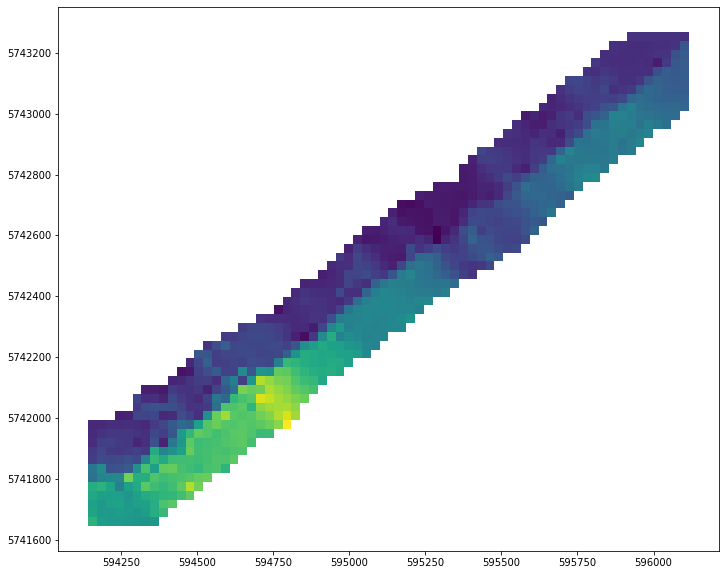

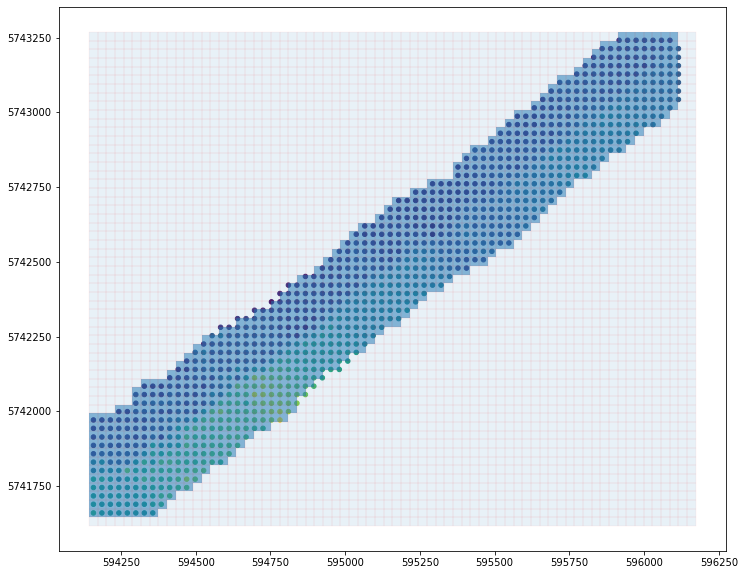

In [35]:
#Optional plotting for reference
grid_data[grid_data.EC>0].plot(column = 'EC', figsize=(14,10))
data_plot = gdf_filtered.plot(column='EC', markersize=20, figsize=(14,10))
output.plot(ax=data_plot, alpha=0.5)
grid.plot(ax=data_plot,alpha=0.1, edgecolor="red", linewidth=0.4)
# output[output.EC==52.36].plot(ax=data_plot,edgecolor="red")

In [26]:
output

,geometry,EC,depth
0,"POLYGON ((588902 5740799, 588917 5740799, 5889...",NaN,3
1,"POLYGON ((588902 5740784, 588917 5740784, 5889...",NaN,3
2,"POLYGON ((588902 5740769, 588917 5740769, 5889...",NaN,3
3,"POLYGON ((588902 5740754, 588917 5740754, 5889...",NaN,3
4,"POLYGON ((588902 5740739, 588917 5740739, 5889...",NaN,3
5,"POLYGON ((588902 5740724, 588917 5740724, 5889...",NaN,3
6,"POLYGON ((588902 5740709, 588917 5740709, 5889...",NaN,3
7,"POLYGON ((588902 5740694, 588917 5740694, 5889...",NaN,3
8,"POLYGON ((588902 5740679, 588917 5740679, 5889...",NaN,3
9,"POLYGON ((588902 5740664, 588917 5740664, 5889...",NaN,3


In [28]:
grid_data[grid_data.has_data]

,geometry,IDs,has_data,EC,depth
26,"POLYGON ((588902 5740409, 588917 5740409, 5889...",[529.0],True,122.39,3
27,"POLYGON ((588902 5740394, 588917 5740394, 5889...",[467.0],True,121.48,3
28,"POLYGON ((588902 5740379, 588917 5740379, 5889...",[406.0],True,115.71,3
29,"POLYGON ((588902 5740364, 588917 5740364, 5889...",[347.0],True,114.18,3
30,"POLYGON ((588902 5740349, 588917 5740349, 5889...",[290.0],True,110.46,3
31,"POLYGON ((588902 5740334, 588917 5740334, 5889...",[234.0],True,107.47,3
67,"POLYGON ((588917 5740409, 588932 5740409, 5889...",[530.0],True,126.24,3
68,"POLYGON ((588917 5740394, 588932 5740394, 5889...",[468.0],True,115.06,3
69,"POLYGON ((588917 5740379, 588932 5740379, 5889...",[407.0],True,108.74,3
70,"POLYGON ((588917 5740364, 588932 5740364, 5889...",[348.0],True,107.50,3
